In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import sys 
sys.path.append('./models/')
from Model import Model 

Importing data

In [2]:
df = pd.read_csv('deaths_and_infections.csv')

# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

Some useful fonctions : 

In [3]:
def exponential_func(x, a, b, c, d):
    return a*np.exp(b*(x-d))+c

In [4]:
# IC with the formula in paper 3: 

def h(theta, x_i):
    return theta[0]*np.exp(theta[1]*(x_i-theta[3]))+theta[2]

def grad_theta(theta, x_i): 
    d_theta=0.0001
    grad=np.zeros(len(theta))
    for i in range(len(theta)): 
        theta_plus=theta.copy()
        theta_plus[i]+=d_theta
        grad[i]=(h(theta_plus,x_i)-h(theta,x_i))/d_theta
    return grad


def compute_A(theta, X): 
    A=np.zeros((len(X), len(theta)))
    for i in range(len(X)): 
        A[i]=grad_theta(theta, X[i])
    return A


def estimate_sigma2(data, prediction,d): 
    return np.sum((data-prediction)**2)/(len(data)-d)

Fitting the data on 15 days: 

[ 0.43431949  0.37881576 -7.67257066 11.80659014]


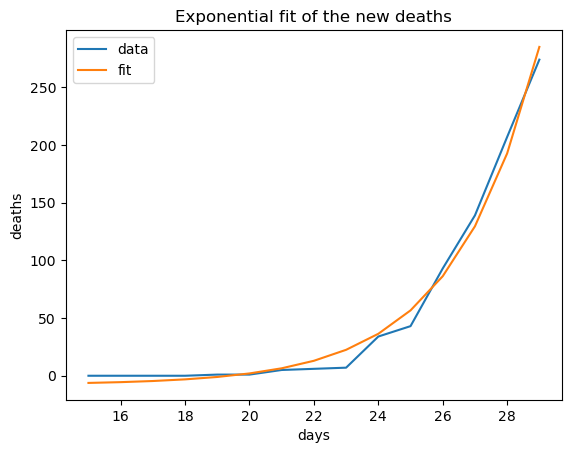

In [5]:
min=15
max=30
interval=[i for i in range(min,max)]
p, cov =curve_fit(exponential_func, dates_of_pandemic[interval], new_deaths[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02, 0], maxfev = 10000)
print(p)
plt.plot(dates_of_pandemic[interval], new_deaths[interval], label='data')
plt.plot(dates_of_pandemic[interval], exponential_func(dates_of_pandemic[interval], *p), label='fit')
plt.legend()
plt.xlabel('days')
plt.ylabel('deaths')
plt.title('Exponential fit of the new deaths')
plt.show()

In [6]:
def objective_function(data, theta, X): 
    return 0.5*np.sum((data-h(theta, X))**2)



def hessian_obj_function(data, theta, X): 
    d_theta=0.0001
    hessian=np.zeros((len(theta), len(theta)))
    for i in range(len(theta)): 
        for j in range(len(theta)):
            theta_plus_i=theta.copy()
            theta_plus_j=theta.copy()
            theta_plus_ij=theta.copy()
            theta_plus_i[i]+=d_theta
            theta_plus_j[j]+=d_theta
            theta_plus_ij[i]+=d_theta
            theta_plus_ij[j]+=d_theta
            hessian[i,j]=(objective_function(data, theta_plus_ij, X)-objective_function(data, theta_plus_i, X)-objective_function(data, theta_plus_j, X)+objective_function(data, theta, X))/(d_theta**2)
    return hessian


In [7]:

def f_for_delta_method(train_dates, data, interval): 
    theta, _ = curve_fit(exponential_func, train_dates[interval], data[interval], p0=[ 1.33991316e+01 , 1.21453531e-01,  -1.92062731e+02, 0], maxfev = 10000)
    return theta

def grad_f_for_delta_method(train_dates, data, interval): 
    d_n=0.1
    grad=np.zeros(( len(data), 4) )
    for i in range(len(data)): 
        data_plus=data.copy()
        data_plus[i]+=d_n
        grad[i]=(f_for_delta_method(train_dates, data, interval)-f_for_delta_method(train_dates, data, interval))/d_n
    return grad


In [87]:
class ExponentialRegression(Model): 
    def train(self, train_dates, data):
        self.data=data
        self.train_dates=train_dates
        min=len(data)-15
        max=len(data)-1
        interval=[i for i in range(min,max)]
        self.interval=interval
        self.p, self.cov =curve_fit(exponential_func, train_dates[interval], data[interval], p0=[ 1,1,0,-20], maxfev = 1000000)
        self.trained=True


    def predict(self, reach, alpha, method='hessian'):
        assert self.trained, 'The model has not been trained yet'
        a=self.p[0]
        b=self.p[1]
        c=self.p[2]
        d=self.p[3]
        window_prediction=np.array([i for i in range(len(self.train_dates), len(self.train_dates) + reach )])
      
        prediction=exponential_func(window_prediction,a,b,c,d)

        if method == 'covariance': # we implemented four methods to compute the confidence intervals
            print('covariance method')
            perr = np.sqrt(np.diag(self.cov))
            self.perr=perr
            
        elif method == 'estimate_sigma': 
            print('estimate sigma')
            sigma2=estimate_sigma2(self.data[self.interval], exponential_func(self.train_dates[self.interval], *self.p), 4)
            A=compute_A(self.p, self.train_dates[self.interval])
            cov=sigma2*np.linalg.inv(np.matmul(A.transpose(), A))/len(self.interval)
            perr=np.sqrt(np.diag(cov))
            self.perr=perr
        elif method == 'hessian':
            print('hessian')
            hessian=hessian_obj_function(self.data[self.interval], self.p, self.train_dates[self.interval])
            self.hess=hessian
            cov=np.linalg.inv(hessian)
            perr=np.sqrt(abs(np.diag(cov)))
            self.perr=perr
        elif method == 'delta': 
            sigma2=estimate_sigma2(self.data[self.interval], exponential_func(self.train_dates[self.interval], *self.p), 4) * np.identity(len(self.data))
            grad=grad_f_for_delta_method(self.train_dates, self.data, self.interval)
            perr = np.sqrt(np.diag(np.matmul(np.matmul(grad.transpose(), sigma2) , grad)))
            self.perr = perr
            
        intervals=[prediction]
        a_sampled=[]
        b_sampled=[]
        c_sampled=[]
        d_sampled=[]
        for i in range(100): 
            a_r= np.random.normal(self.p[0], perr[0], 1)[0]
            b_r=np.random.normal(self.p[1], perr[1], 1)[0]
            c_r=np.random.normal(self.p[2], perr[2], 1)[0]
            d_r=np.random.normal(self.p[3], perr[3], 1)[0]
            a_sampled.append(a_r)
            b_sampled.append(b_r)
            c_sampled.append(c_r)
            d_sampled.append(d_r)
            prediction_sampled=exponential_func(window_prediction,a_r, b_r,c_r, d_r)
            intervals.append(prediction_sampled)
        self.a_sampled=a_sampled
        self.b_sampled=b_sampled
        self.c_sampled=c_sampled
        self.d_sampled=d_sampled
        intervals=np.array(intervals).transpose()
        self.intervals=intervals
        ci_low=np.array([np.quantile(intervals[i], alpha/2) for i in range(reach)])
        ci_high=np.array([np.quantile(intervals[i],1-alpha/2) for i in range(reach)])
        return prediction, [ci_low, ci_high]




We test the model to make predictions 7 days ahead. The only method that gives coherent confidence intervals is the hessian one. 

Good predictions on the train set but it explodes when the goal is to predict new cases. 

hessian


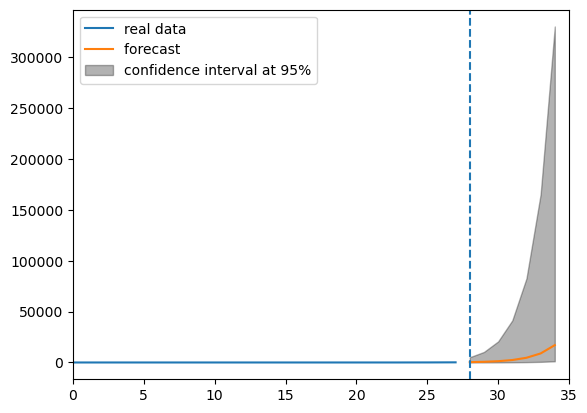

In [88]:
mymodel=ExponentialRegression()
mymodel.train(dates_of_pandemic[:28], new_deaths[:28])
mymodel.plot(7, 0.05)

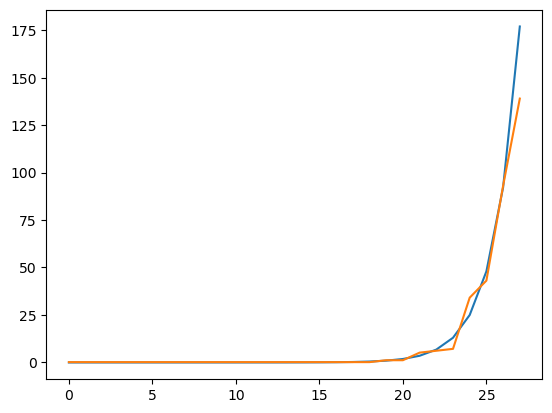

In [89]:
p=mymodel.p
plt.plot(exponential_func(dates_of_pandemic[0:28], *p))
plt.plot(new_deaths[0:28])